In [1]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from censai import PowerSpectrum
from astropy.visualization import ImageNormalize, LogStretch, SqrtStretch
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm, Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable
from glob import glob
from tqdm import tqdm
from scipy.stats import chi2
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.interpolate import interpn

plt.style.use("science") # requires SciencePlots
params = {'legend.fontsize': 27,
          'figure.figsize': (10, 10),
         'axes.labelsize': 27,
         'axes.titlesize': 30,
         'xtick.labelsize':30,
         'ytick.labelsize':30,
         'figure.titlesize': 40,
          'xtick.major.size': 8,
          'xtick.minor.size': 4,
         'xtick.major.width': 1,
          'xtick.minor.width': 1,
         'ytick.major.size': 8,
          'ytick.minor.size': 4,
         'ytick.major.width': 1,
          'ytick.minor.width': 1,

         }
pylab.rcParams.update(params)


nu = 128**2  # degrees of freedom

In [2]:
hf = h5py.File(os.path.join(os.getenv("CENSAI_PATH"), "results", "final_results_likelihood_ewc_optim_lr1e-6_lam2e5.h5"), "r")
list(hf.keys())

['chi_squared',
 'chi_squared_reoptimized',
 'chi_squared_reoptimized_series',
 'kappa',
 'kappa_coherence_spectrum',
 'kappa_coherence_spectrum_reoptimized',
 'kappa_fov',
 'kappa_frequencies',
 'kappa_optim_mse',
 'kappa_optim_mse_series',
 'kappa_pred',
 'kappa_pred_reoptimized',
 'noise_rms',
 'observation',
 'observation_coherence_spectrum',
 'observation_coherence_spectrum2',
 'observation_coherence_spectrum_reoptimized',
 'observation_fov',
 'observation_frequencies',
 'observation_pred',
 'observation_pred_reoptimized',
 'psf',
 'psf_fwhm',
 'source',
 'source_coherence_spectrum',
 'source_coherence_spectrum2',
 'source_coherence_spectrum_reoptimized',
 'source_fov',
 'source_frequencies',
 'source_optim_mse',
 'source_optim_mse_series',
 'source_pred',
 'source_pred_reoptimized']

# Chi squared vs noise

4


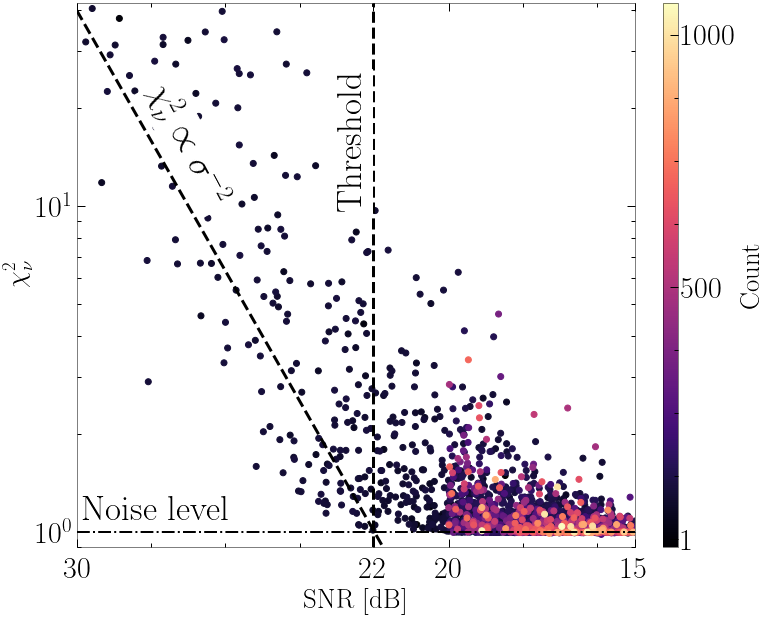

In [3]:
noise_rms = hf["noise_rms"][:]
chisq_ro = hf["chi_squared_reoptimized"][:]
chisq = hf["chi_squared"][:, -1] # last step of the rim

fig, ax = plt.subplots()
cmap = "magma"
ticks = [1, 500, 1000]

x = 10**np.linspace(-3, -1, 100)
# find C in chi^2 = C sigma^{-1}
criteria = chi2.ppf(1 - 0.05, nu) / nu
threshold_ewc = np.min(noise_rms[chisq_ro <= criteria])
C_ewc = criteria * threshold_ewc **2
y = C_ewc * x**(-2)
plt.plot(np.log10(x), y, "k--", lw=3)
plt.axvline(np.log10(threshold_ewc), color="k", ls="--", lw=3)


# =============== 
# plt.plot(np.log10(noise_rms), chisq, "k.", alpha=0.5, label=r"Baseline $\varphi_{\mathcal{D}}^{\star}$")
# plt.plot(np.log10(noise_rms), chisq_ro, "r.", alpha=0.5, label=r"Fine Tuned $\hat{\varphi}_{\mathrm{MAP}}$")
# plt.legend(loc=1, frameon=True, framealpha=1)
# ================

plt.annotate(r"$\chi^2_\nu \propto \sigma^{-2}$", xy=(0.115, 0.63), xycoords="axes fraction", rotation=-62, fontsize=35, backgroundcolor="w")
plt.annotate("Threshold", xy=(np.log10(0.8*threshold_ewc), 10), fontsize=35, rotation=90, backgroundcolor="w")
plt.annotate("Noise level ", xy=(1.05e-3, 1.1), fontsize=35)

plt.ylim(0.9)
plt.yscale("log")
plt.xlim(-3, np.log10(noise_rms.max()))
x = [-3, np.log10(threshold_ewc), -2, -1.5]
labels = [r"30", f"{-10*np.log10(threshold_ewc):.0f}", "20", "15"]
plt.xticks(x, labels)
plt.gca().set_xticks(-np.arange(14, 30, 2)/10, minor=True)
plt.xlim(-3, -1.5)
plt.gca().tick_params(axis='x', pad=10)

plt.annotate("Noise level", xy=(0.01, 0.05), xycoords="axes fraction", fontsize=35)
plt.axhline(1, color="k", ls="-.", alpha=1, lw=2)
plt.ylabel(r"$\chi^2_\nu$")
plt.xlabel(r"SNR [dB]")

# added colormap, remove if we want to compare baseline and fine tuning
x = np.log10(noise_rms)
y = np.log(chisq_ro)
data, x_edges, y_edges = np.histogram2d(x, y, bins=2000, density=True)
x_bins = 0.5 * (x_edges[1:] + x_edges[:-1])
y_bins = 0.5 * (y_edges[1:] + y_edges[:-1])
z = interpn((x_bins, y_bins), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)
print(np.isnan(z).sum())
z[np.where(np.isnan(z))] = 1
# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
norm = Normalize(vmin=z.min(), vmax=z.max())
plt.scatter(np.log10(noise_rms), chisq_ro, c=z, cmap=cmap, norm=norm)
sm = cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
box = ax.get_position()
cax = plt.axes([box.x0*1.01 + box.width * 1.05, box.y0, 0.02, box.height])
fig.colorbar(sm, cax=cax, ticks=ticks)
cax.set_ylabel('Count');
# plt.savefig("../../../Papers/Censai-paper/figures/chisq_vs_noise_ewc.png")

# Likelihood and Loss difference

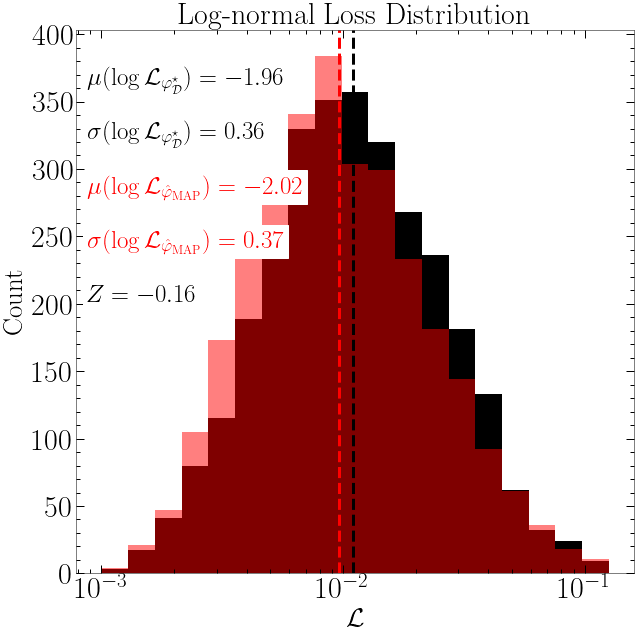

In [4]:
## Loss difference
source_mse_baseline = hf["source_optim_mse_series"][:, 0]
kappa_mse_baseline = hf["kappa_optim_mse_series"][:, 0]
source_mse_ft = hf["source_optim_mse"][:]
kappa_mse_ft = hf["kappa_optim_mse"][:]

loss_rim = source_mse_baseline + kappa_mse_baseline
loss_ft = source_mse_ft + kappa_mse_ft
bins = np.logspace(-3, -0.9, 20)

plt.hist(loss_rim, color="k", bins=bins)
plt.hist(loss_ft, color="r", alpha=0.5, bins=bins)


mu_rim = np.mean(np.log10(loss_rim))
sigma_rim = np.std(np.log10(loss_rim))
mu_ft = np.mean(np.log10(loss_ft))
sigma_ft = np.std(np.log10(loss_ft))
Z = (mu_ft - mu_rim) / sigma_rim

plt.axvline(10**mu_rim, color="k", ls="--", lw=3)
plt.axvline(10**mu_ft, color="r", ls="--", lw=3)
plt.annotate(r"$\mu(\log \mathcal{L}_{\varphi_{\mathcal{D}}^{\star}}) = %.2f$" % (mu_rim), xy=(0.02, 0.9), xycoords="axes fraction", fontsize=25, backgroundcolor="w")
plt.annotate(r"$\sigma(\log \mathcal{L}_{\varphi_{\mathcal{D}}^{\star}}) = %.2f$" % (sigma_rim), xy=(0.02, 0.8), xycoords="axes fraction", fontsize=25, backgroundcolor="w")
plt.annotate(r"$\mu(\log \mathcal{L}_{\hat{\varphi}_{\mathrm{MAP}}}) = %.2f$" % (mu_ft), xy=(0.02, 0.7), xycoords="axes fraction", fontsize=25, backgroundcolor="w", color="r")
plt.annotate(r"$\sigma(\log \mathcal{L}_{\hat{\varphi}_{\mathrm{MAP}}}) = %.2f$" % (sigma_ft), xy=(0.02, 0.6), xycoords="axes fraction", fontsize=25, backgroundcolor="w", color="r")
plt.annotate(r"$Z = %.2f$" % (Z), xy=(0.02, 0.5), xycoords="axes fraction", fontsize=25, backgroundcolor="w")
plt.title("Log-normal Loss Distribution")
plt.xlabel(r"$\mathcal{L}$")
plt.ylabel("Count")
plt.xscale("log")
# plt.savefig("../../../Papers/Censai-paper/figures/loss_distribution.png")

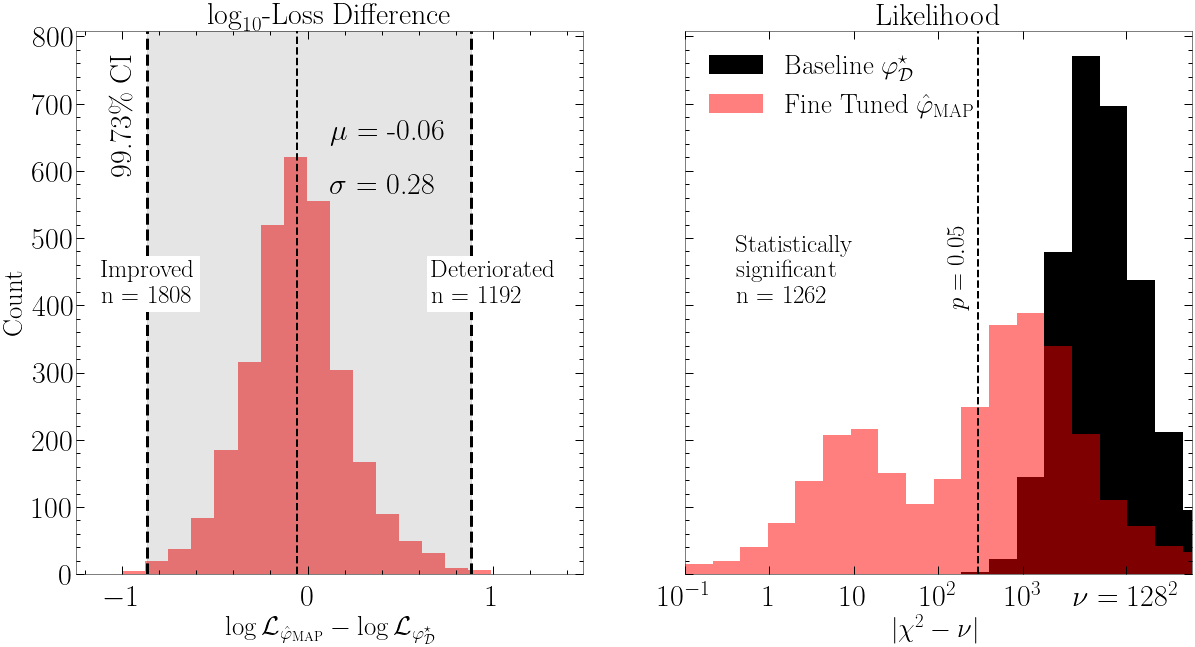

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

n = loss_ft.size

# std_rim = np.std(loss_rim)
diff = (np.log10(loss_ft) - np.log10(loss_rim))#/sigma_rim
# diff = (np.log10(loss_ft) - mu_rim)/sigma_rim

mean = np.mean(diff)
std = np.std(diff)

# diff = np.maximum(np.minimum((np.log10(loss_ft) - np.log10(loss_rim))/sigma_rim, 2.5), -2.5)
diff = np.maximum(np.minimum((np.log10(loss_ft) - np.log10(loss_rim)), 2.5), -2.5)
# diff = np.maximum(np.minimum((np.log10(loss_ft) - mu_rim)/sigma_rim, 2.5), -2.5)


out = ax1.hist(diff, bins=20, color="r", alpha=0.5)
ax1.axvline(mean, color="k", ls="--", lw=2)
ax1.annotate(fr"$\mu$ = {mean:.2f}", xy=(0.5, 0.8), xycoords="axes fraction", fontsize=30)
ax1.annotate(fr"$\sigma$ = {std:.2f}", xy=(0.5, 0.7), xycoords="axes fraction", fontsize=30)

# ax1.annotate(fr"$\mu$ = {mean:.1f}", xy=(0.35, 0.7), xycoords="axes fraction", fontsize=30, rotation=90)
# ax1.annotate(f"Mode = {out[1][np.argmax(out[0])]:.1f}", xy=(0.65, 0.8), xycoords="axes fraction", fontsize=30)
ax1.annotate(f"Deteriorated \n n = {np.sum(diff > 0):d}", xy=(0.7, 0.5),  xycoords="axes fraction", fontsize=25, backgroundcolor="w")
ax1.annotate(f"Improved \n n = {np.sum(diff < 0):d}", xy=(0.05, 0.5),  xycoords="axes fraction", fontsize=25, backgroundcolor="w")
ci_99 = np.percentile(diff, 99.73)
ci_1 = np.percentile(diff, 0.27)
ax1.axvline(ci_99, color="k", ls="--", lw=3)
ax1.axvline(ci_1, color="k", ls="--", lw=3)
ax1.axvspan(ci_1, ci_99, color="k", alpha=0.1)
ax1.annotate("99.73\% CI", xy=(ci_1 - 0.2, 600), fontsize=30, rotation=90)

# ax1.set_xlim(-2.6, 2.6)
ax1.tick_params(axis='x', pad=10)
ax1.set_ylabel("Count")
ax1.set_title(r"$\log_{10}$-Loss Difference")
# ax1.set_xlabel(r"$\displaystyle \frac{\log \mathcal{L}_{\hat{\varphi}_{\mathrm{MAP}}} - \log \mathcal{L}_{\varphi_{\mathcal{D}}^{\star}} }{\sigma(\log \mathcal{L}_{\varphi_{\mathcal{D}}^{\star}})}$");
ax1.set_xlabel(r"$\displaystyle \log \mathcal{L}_{\hat{\varphi}_{\mathrm{MAP}}} - \log \mathcal{L}_{\varphi_{\mathcal{D}}^{\star}}$");


nu = 128**2
p = 0.05 # statistical significance
criteria = nu - chi2.ppf(p, nu)

bins = np.logspace(-1, np.log10(10*nu), 20)
ax2.hist(np.abs(chisq*nu - nu), bins=bins, histtype="stepfilled", color="k", label=r"Baseline $\varphi_{\mathcal{D}}^{\star}$");
ax2.hist(np.abs(np.array(chisq_ro)*nu - nu), bins=bins, histtype="stepfilled", color="r", alpha=0.5, label=r"Fine Tuned $\hat{\varphi}_{\mathrm{MAP}}$");
ax2.set_xscale("log")
ax2.axvline(criteria, ls="--", lw=2, color="k")
ax2.annotate(r"$p = 0.05$", xy=(criteria-170, 400), rotation=90, fontsize=25, backgroundcolor="w")
ax2.annotate(f"Statistically \n significant \n n = {np.sum(np.abs(chisq_ro*nu - nu) < criteria):d}", xy=(0.1, 0.5), xycoords="axes fraction", fontsize=25, backgroundcolor="w")


x = [1e-1, 1e0, 1e1, 1e2, 1e3, nu]
labels = [r"$10^{-1}$", r"$1$", r"$10$", r"$10^{2}$", r"$10^{3}$", r"$\nu=128^2$"]
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.set_xlim(1e-1, 1e5)
ax2.tick_params(axis='x', pad=10)
ax2.set_title("Likelihood")
ax2.set_xlabel(r"$|\chi^2 - \nu|$")
ax2.legend(loc=2)
# plt.savefig("../../../Papers/Censai-paper/figures/loss_and_likelihood.png")

In [6]:
from scipy.stats import norm, t

mean_norm, std_norm = norm.fit(diff)
t_shape_parameter, mean_t, std_t = t.fit(diff)

hist, bin_edges = np.histogram(diff, bins=10, density=True)
z_bins = (bin_edges[:-1] + bin_edges[1:]) / 2
rss_norm = np.sum((hist - norm.pdf(z_bins, mean_norm, std_norm))**2)
rss_t = np.sum((hist - t.pdf(z_bins, t_shape_parameter, mean_norm, std_norm))**2)
print(f"Norm RSS = {rss_norm} with mu = {mean_norm}, sigma = {std_norm}")
print(f"Student-t RSS = {rss_t} with nu = {t_shape_parameter}, mu = {mean_t}, sigma = {std_t}")

Norm RSS = 0.052780595594066164 with mu = -0.05772191286087036, sigma = 0.2752023935317993
Student-t RSS = 0.06121733733429309 with nu = 7.563595861618982, mu = -0.061865107923981796, sigma = 0.23728215636610916


# Random set of fine-tuned reconstructions

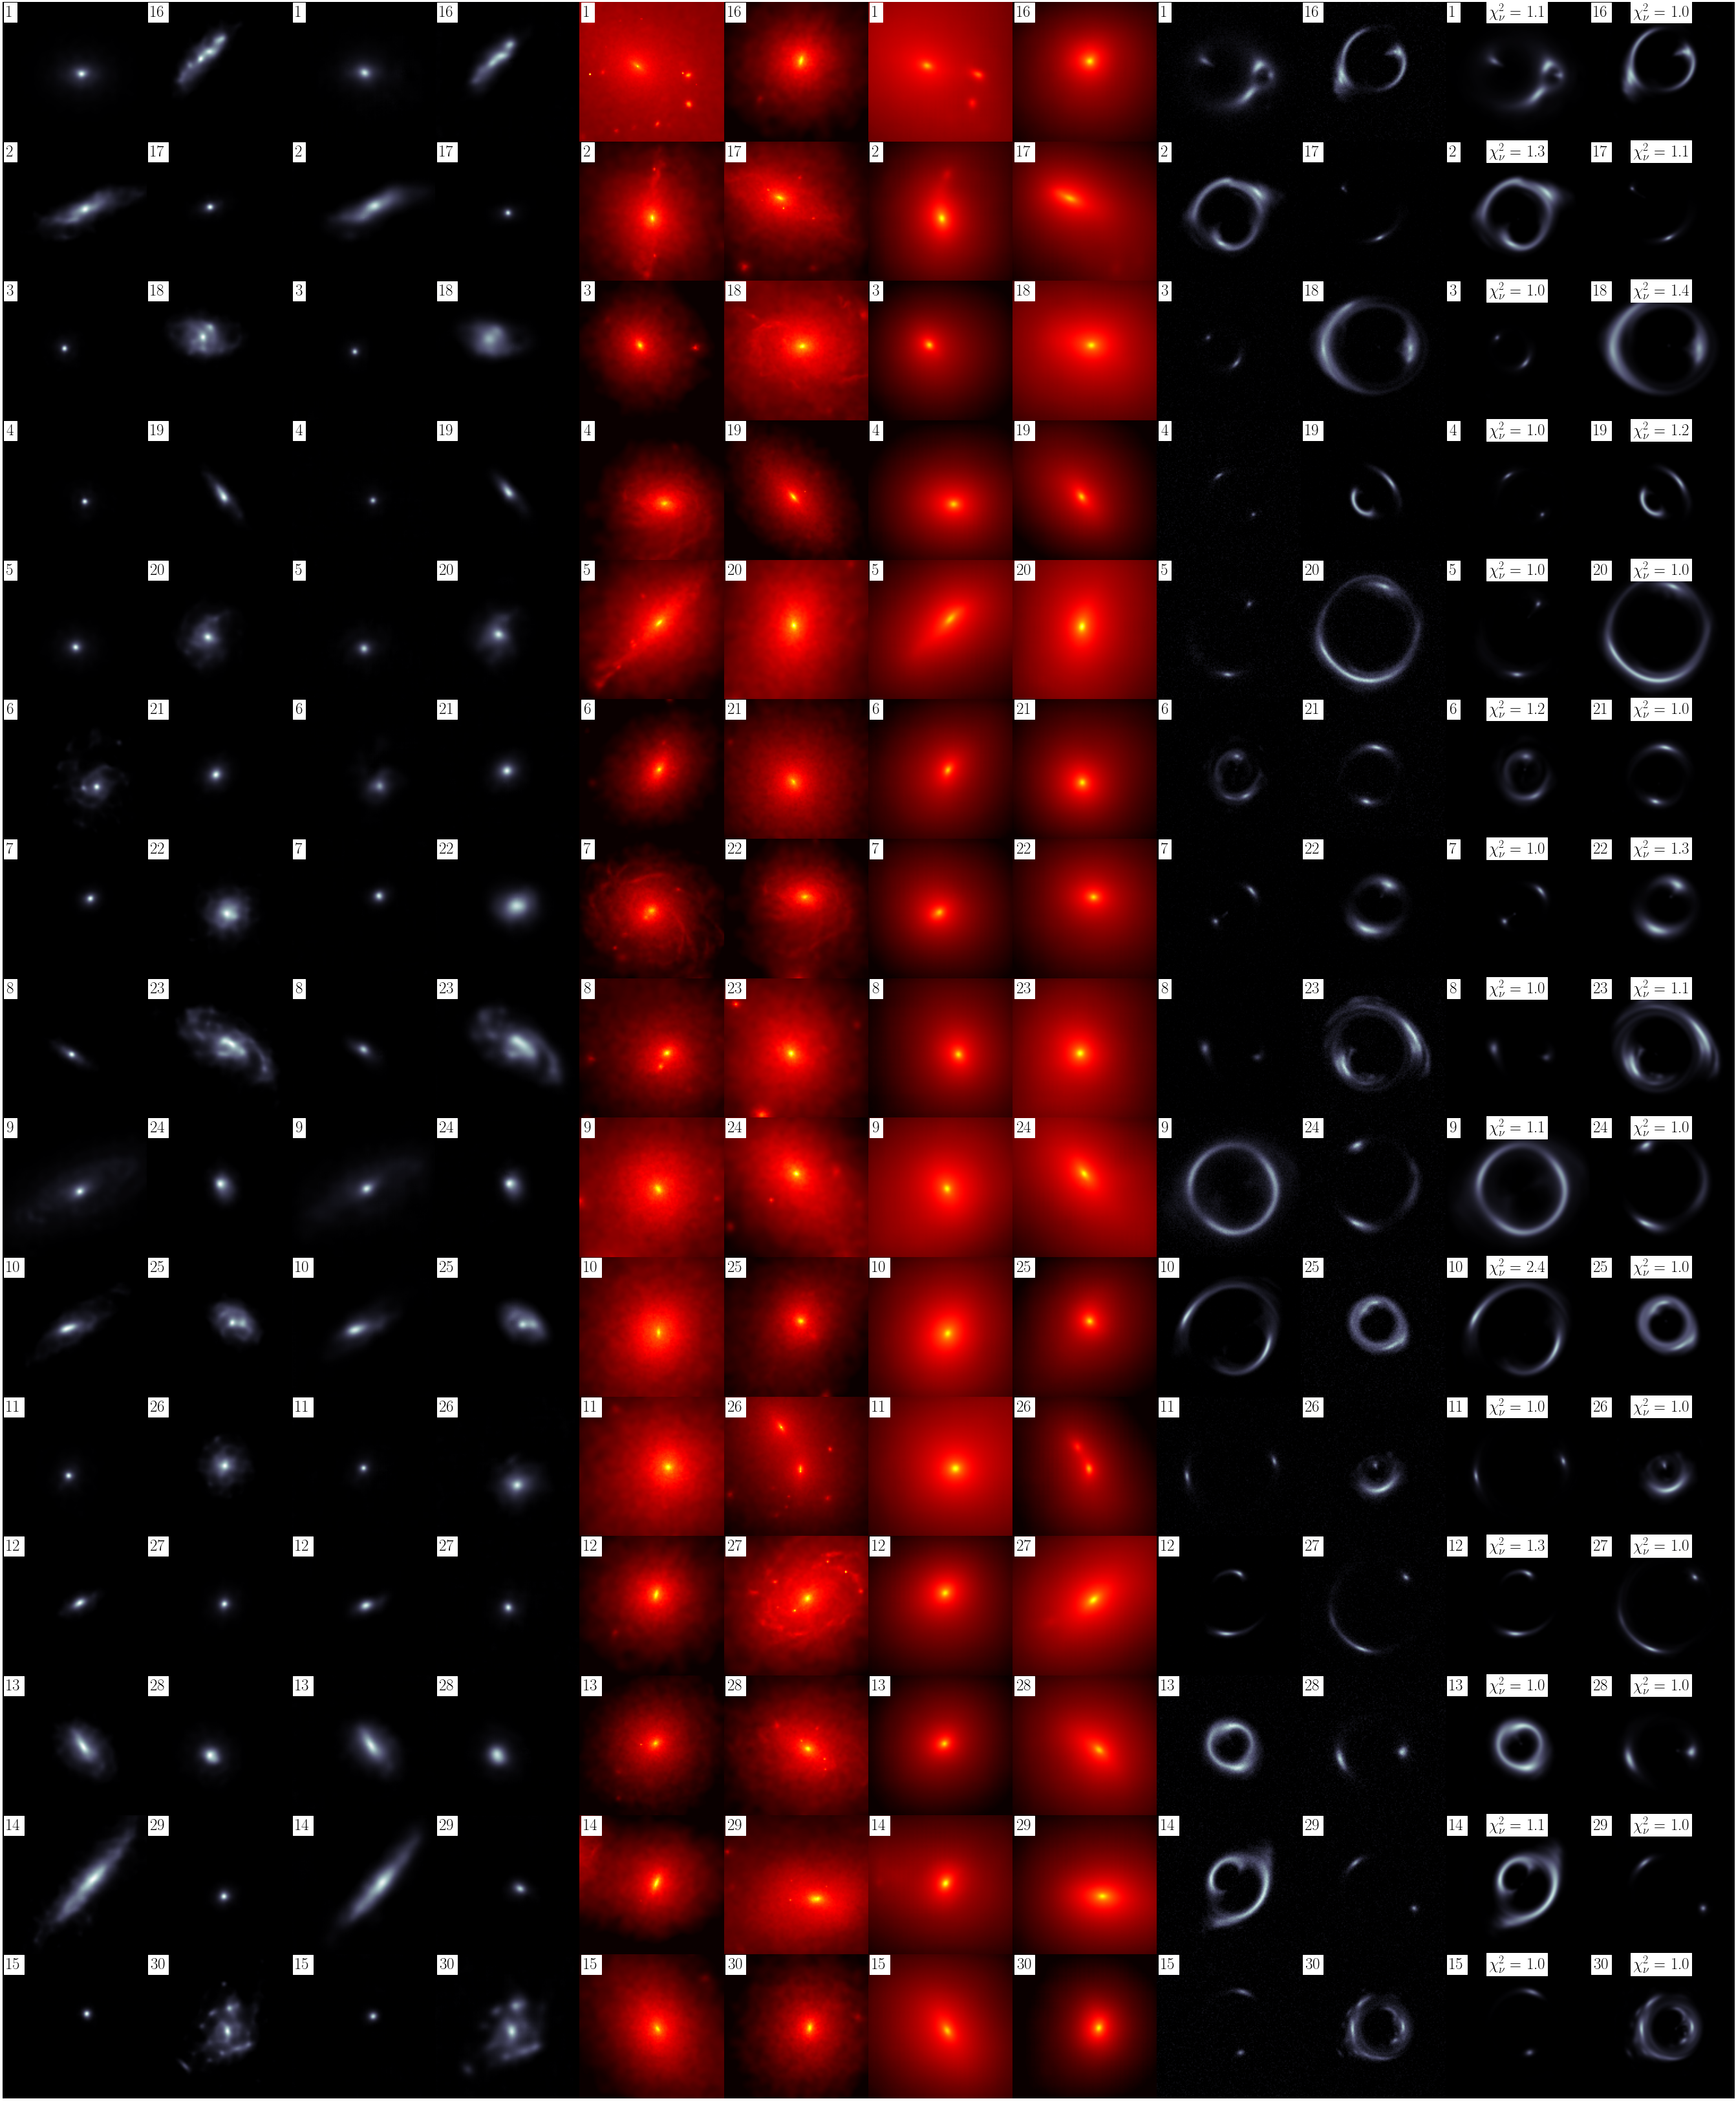

In [7]:
N = 15
np.random.seed(102)
index = np.random.choice(range(3000), replace=False, size=2*N)

fig, axs = plt.subplots(N, 12, figsize=(48, 4 * N))
for m in range(2):
    for i in range(N):
        j = index[i + N * (m%2)]
        lens = hf[f"observation"][j].squeeze()
        source = hf[f"source"][j].squeeze()
        kappa = hf[f"kappa"][j].squeeze()
        lens_pred = hf["observation_pred_reoptimized"][j].squeeze() # reoptimized = fine-tuned
        source_pred = hf[f"source_pred_reoptimized"][j].squeeze()
        kappa_pred = hf[f"kappa_pred_reoptimized"][j].squeeze()
        chi_squared = hf[f"chi_squared_reoptimized"][j].squeeze()
        noise_rms = hf["noise_rms"][j]
        intensity_cmap = "bone"
        a = 100#int(1/noise_rms)
        i_min = 0.01#noise_rms
#         i_norm = ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)
        i_norm = Normalize(vmin=0, vmax=1)
        
        axs[i, 0+m%2].imshow(source, cmap=intensity_cmap, norm=i_norm, origin="lower")
        axs[i, 2+m%2].imshow(source_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
        axs[i, 4+m%2].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
        axs[i, 6+m%2].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
        axs[i, 8+m%2].imshow(lens, cmap=intensity_cmap, norm=i_norm, origin="lower")
        axs[i, 10+m%2].imshow(lens_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
        axs[i, 10+m%2].annotate(fr"$\chi^2_\nu =$ {chi_squared:.1f}", xy=(0.3, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")

for i in range(N):            
    for j in range(12):
        k = 1 + i + N * (j%2)
        axs[i, j].axis("off")
        axs[i, j].annotate(f"{k}", xy=(0.03, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")
        

plt.subplots_adjust(wspace=0, hspace=-0.11)


# Cherry picked sample of fine-tuned reconstructions

2.3333333333333335 4.5204735
13.566666666666666 4.556677
19.733333333333334 4.437176
26.833333333333332 5.267077
36.266666666666666 4.2080793
38.86666666666667 3.9319682
50.9 5.6059675
67.10000000000001 4.997626
68.03333333333333 10.9890585
85.39999999999999 8.283321
95.03333333333333 18.423779


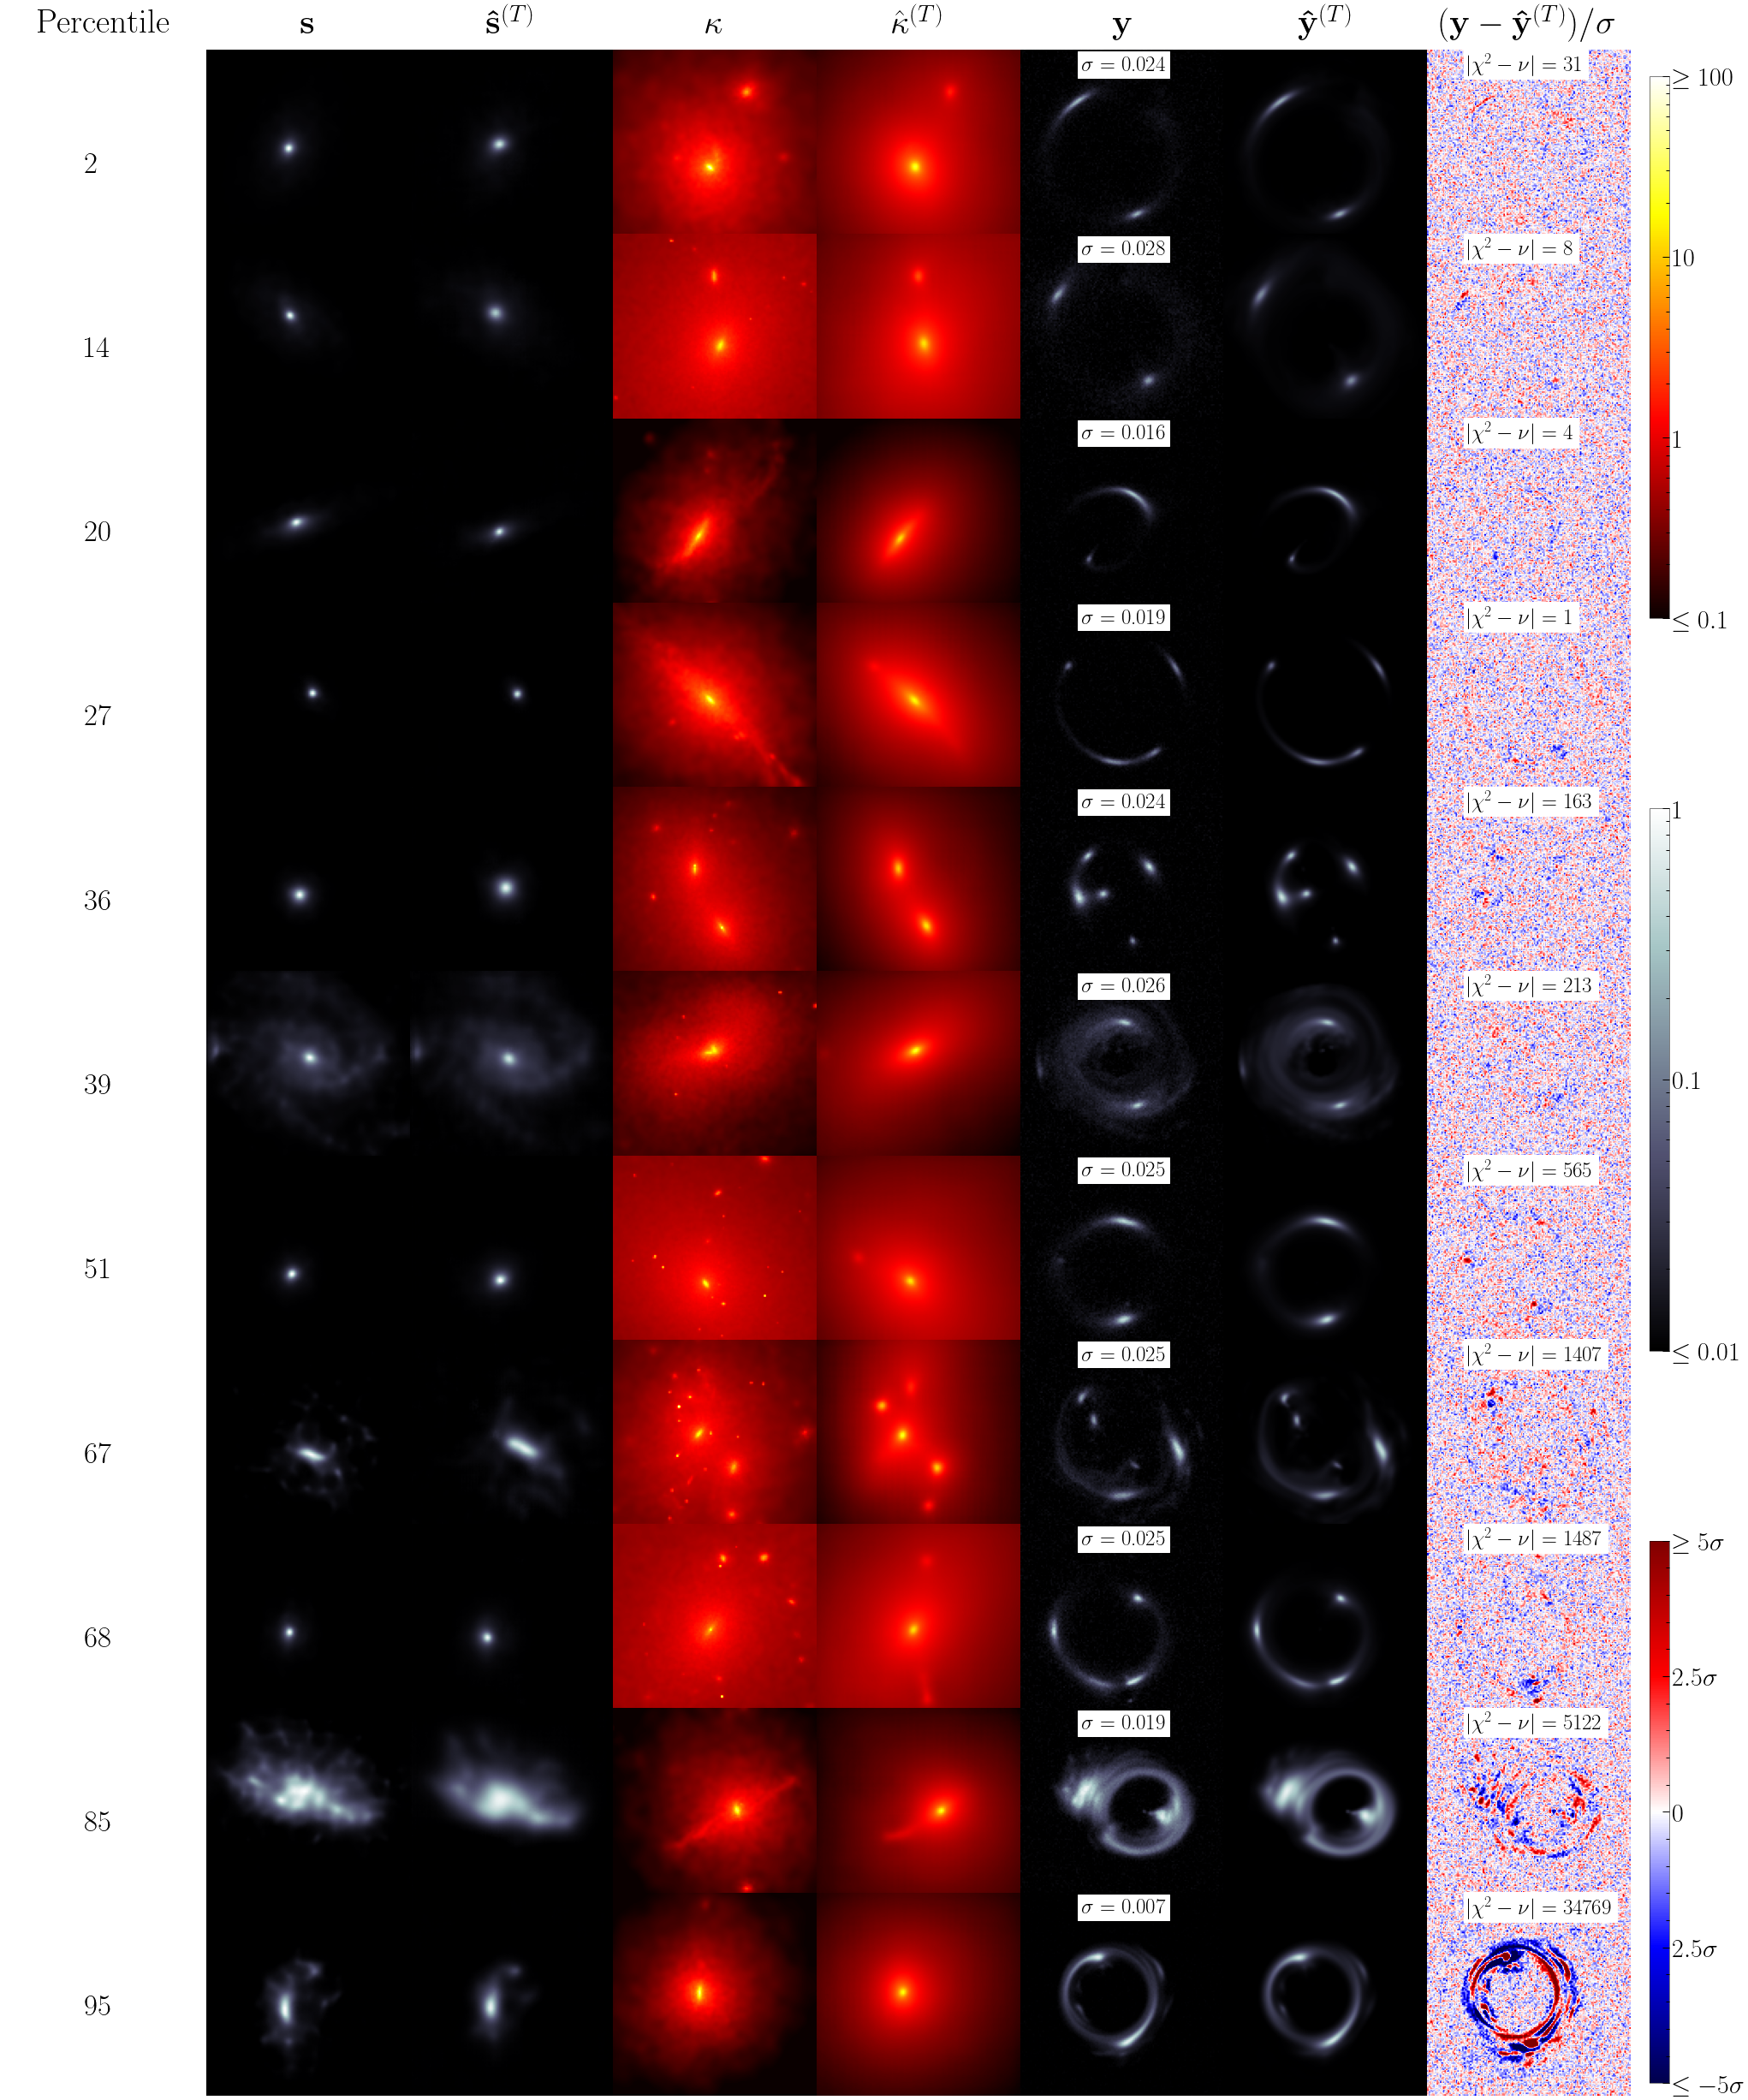

In [8]:
# order examples by their fine-tuend chi2
indices = np.argsort(chisq_ro)
_indices = [70, 407, 592, 805, 1088, 1166,  1527, 2013, 2041, 2562, 2851] # cherry-picks
# 2013 is madness (4 blobs)
# 1890: spiral galaxy with MSD
# 70: two blob
# 592 high eccentricity
# 1088: 5 images
# 1527: substructure
# 2041: 3-4 images? + ring + 2 substructure
# 2562: Modeled a jet?
# 2851: beyong precision limit (~0.01 sigma), simple ring
# 1166: nice spiral galaxy
N = len(_indices)
fig, axs = plt.subplots(N, 8, figsize=(32, 4 * N))
start = 0

for i, ell in enumerate(_indices):
    j = indices[ell]
    lens = hf[f"observation"][j].squeeze()
    source = hf[f"source"][j].squeeze()
    kappa = hf[f"kappa"][j].squeeze()
    lens_pred = hf[f"observation_pred_reoptimized"][j].squeeze()
    source_pred = hf[f"source_pred_reoptimized"][j].squeeze()
    kappa_pred = hf[f"kappa_pred_reoptimized"][j].squeeze()
    chi_squared = hf["chi_squared_reoptimized"][j]
    noise_rms = hf["noise_rms"][j]
#     intensity_cmap = "twilight"
    intensity_cmap = "bone"
    a = 100
    i_min = 1e-2
#     i_norm = ImageNormalize(stretch=LogStretch(a), vmin=i_min, vmax=1)
    i_norm = ImageNormalize(vmin=0, vmax=1)

    axs[i, 1].imshow(source, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 2].imshow(source_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
    
    axs[i, 3].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 4].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    
    axs[i, 5].imshow(lens, cmap=intensity_cmap, norm=i_norm, origin="lower")
    axs[i, 5].annotate(fr"$\sigma =$ {noise_rms:.3f}", xy=(0.3, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")
    axs[i, 6].imshow(lens_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
    residual = (lens - lens_pred)/noise_rms
    print(ell/len(indices) * 100, np.abs(residual).max())
    axs[i, 7].imshow(residual, cmap="seismic", vmin=-5, vmax=5, origin="lower")
    
    axs[i, 7].annotate(fr"$|\chi^2 - \nu| =$ {np.abs(chi_squared*128**2 - 128**2):.0f}", xy=(0.2, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")
    axs[i, 0].annotate(fr"{ell/len(indices) * 100:.0f}", xy=(0.4, 0.4), xycoords="axes fraction", size=35)


    
for i in range(N):            
    for j in range(8):
        axs[i, j].axis("off")

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.67, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100)), cax=cbar_ax, ticks=[0.1, 1, 10, 100])
cbar_ax.set_yticklabels(["$\leq 0.1$", "1", "10", "$\geq 100$"], fontsize=30) 
# cbar_ax.set_ylabel(r"Convergence", rotation=270, labelpad=50, fontsize=40)
cbar_ax.yaxis.set_label_position("right")


fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.33 + .07, 0.01, 0.2])
# fig.colorbar(ScalarMappable(cmap=intensity_cmap, norm=i_norm), cax=cbar_ax, ticks=[0, 0.5, 1])
fig.colorbar(ScalarMappable(cmap=intensity_cmap, norm=LogNorm(vmin=1e-2, vmax=1)), cax=cbar_ax, ticks=[0.01, 0.1, 1.])
# cbar_ax.set_yticklabels(["0", "0.5", "1"], fontsize=30)
cbar_ax.set_yticklabels(["$\leq 0.01$", "0.1", "1"], fontsize=30) 
# cbar_ax.set_ylabel(r"Intensity", rotation=270, labelpad=100, fontsize=40)
cbar_ax.yaxis.set_label_position("right")

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.13, 0.01, 0.2])
fig.colorbar(ScalarMappable(cmap="seismic", norm=Normalize(vmin=-5, vmax=5)), cax=cbar_ax, ticks=[-5, -2.5, 0, 2.5, 5])
cbar_ax.set_yticklabels(["$\leq -5\sigma$", "$2.5\sigma$", "0", "$2.5\sigma$", "$\geq 5\sigma$"], fontsize=30) 
# cbar_ax.set_ylabel(r"Residuals", rotation=270, labelpad=60, fontsize=40)
cbar_ax.yaxis.set_label_position("right")


axs[0, 0].set_title(r"Percentile", pad=20, fontsize=40)
axs[0, 1].set_title(r"$\mathbf{s}$", pad=20, fontsize=40)
axs[0, 2].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
axs[0, 3].set_title("$\kappa$", pad=20, fontsize=40)
axs[0, 4].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
axs[0, 5].set_title("$\mathbf{y}$", pad=20, fontsize=40)
axs[0, 6].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=40)
axs[0, 7].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/\sigma$", pad=20, fontsize=40)
plt.subplots_adjust(wspace=0, hspace=-0.1)


# Highlight example

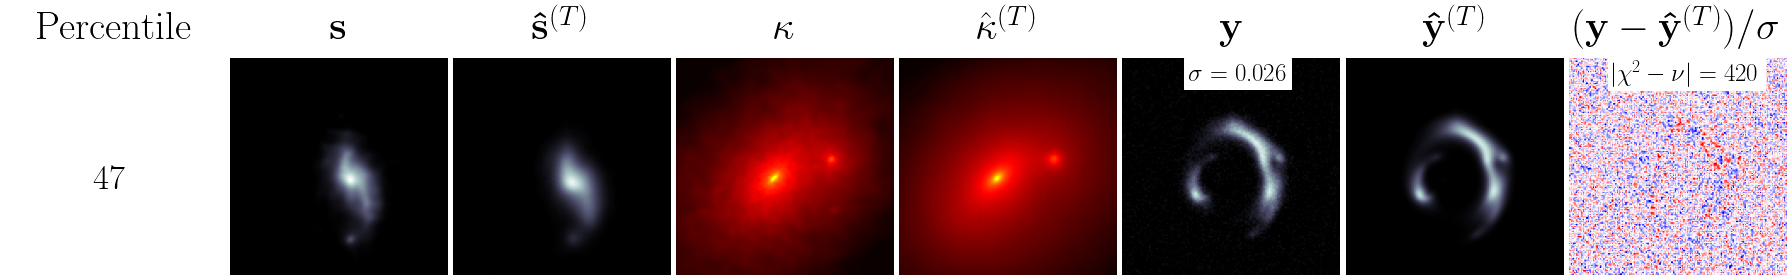

In [9]:
ell = 1396
fig, axs = plt.subplots(1, 8, figsize=(32, 4))
start = 0

j = indices[ell]
lens = hf[f"observation"][j].squeeze()
source = hf[f"source"][j].squeeze()
kappa = hf[f"kappa"][j].squeeze()
lens_pred = hf[f"observation_pred_reoptimized"][j].squeeze()
source_pred = hf[f"source_pred_reoptimized"][j].squeeze()
kappa_pred = hf[f"kappa_pred_reoptimized"][j].squeeze()
chi_squared = hf["chi_squared_reoptimized"][j]
noise_rms = hf["noise_rms"][j]
intensity_cmap = "bone"

i_norm = ImageNormalize(vmin=0, vmax=1)

axs[1].imshow(source, cmap=intensity_cmap, norm=i_norm, origin="lower")
axs[2].imshow(source_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")

axs[3].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
axs[4].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")

axs[5].imshow(lens, cmap=intensity_cmap, norm=i_norm, origin="lower")
axs[5].annotate(fr"$\sigma =$ {noise_rms:.3f}", xy=(0.3, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")
axs[6].imshow(lens_pred, cmap=intensity_cmap, norm=i_norm, origin="lower")
residual = (lens - lens_pred)/noise_rms
axs[7].imshow(residual, cmap="seismic", vmin=-5, vmax=5, origin="lower")

axs[7].annotate(fr"$|\chi^2 - \nu| =$ {np.abs(chi_squared*128**2 - 128**2):.0f}", xy=(0.2, 0.9), xycoords="axes fraction", size=25, backgroundcolor="w")
axs[0].annotate(fr"{ell/len(indices) * 100:.0f}", xy=(0.4, 0.4), xycoords="axes fraction", size=35)

for j in range(8):
    axs[j].axis("off")

axs[0].set_title(r"Percentile", pad=20, fontsize=40)
axs[1].set_title(r"$\mathbf{s}$", pad=20, fontsize=40)
axs[2].set_title(r"$\mathbf{\hat{s}}^{(T)}$", pad=20, fontsize=40)
axs[3].set_title("$\kappa$", pad=20, fontsize=40)
axs[4].set_title("$\hat{\kappa}^{(T)}$", pad=20, fontsize=40)
axs[5].set_title("$\mathbf{y}$", pad=20, fontsize=40)
axs[6].set_title("$\mathbf{\hat{y}}^{(T)}$", pad=20, fontsize=40)
axs[7].set_title("$(\mathbf{y} - \mathbf{\hat{y}}^{(T)})/\sigma$", pad=20, fontsize=40)
plt.subplots_adjust(wspace=0, hspace=-0.1)

# Learning curve

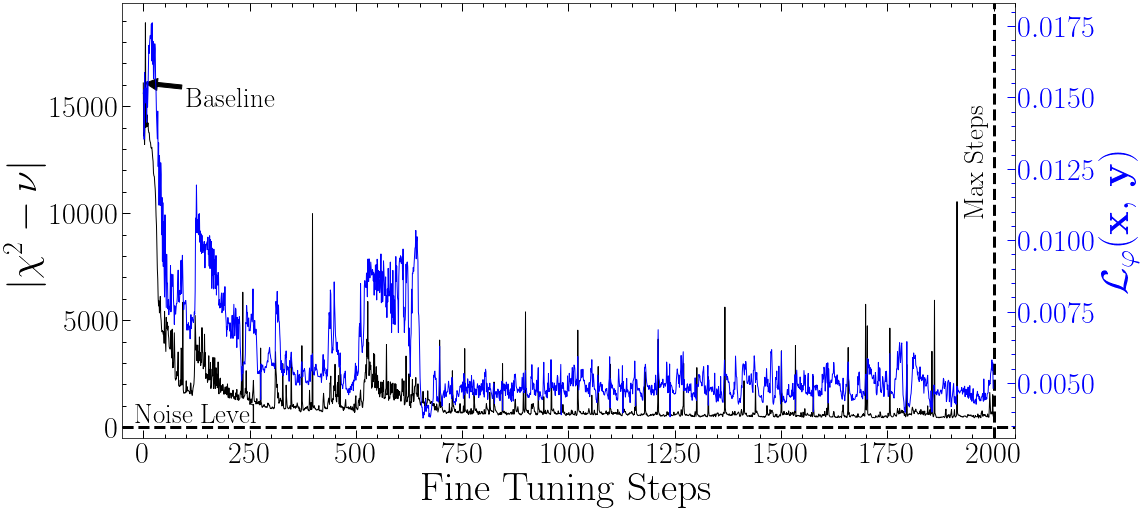

In [10]:
# loss and chi2 = 0 means the early stopping was applied
ell = 1396
j = indices[ell]

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(111) # Primary y
ax2 = ax.twinx() # Secondary y

ax.plot(np.abs(hf["chi_squared_reoptimized_series"][j] * nu - nu), color="k")  # Objective function in black
ax2.plot(hf["source_optim_mse_series"][j] + hf["kappa_optim_mse_series"][j], color="b") # Loss in blue, not optimised during fine-tuning (this is an oracle metric)
ax.axhline(1, color="k", ls="--", lw=3)
ax.axvline(2000, color="k", ls="--", lw=3)
ax.annotate("Max Steps", rotation=90, xy=(1930, 10000), fontsize=27)

ax.annotate("Noise Level", xy=(-20, 200), fontsize=27, weight="bold")
ax.annotate("Baseline", xy=(0, np.abs(hf["chi_squared_reoptimized_series"][j][0] * nu - nu)), xycoords='data', arrowprops=dict(facecolor='black', shrink=0.05), xytext=(100, 15000), fontsize=27)
ax.set_ylabel(r"$|\chi^2 - \nu|$", fontsize=40)
ax.set_xlabel("Fine Tuning Steps", fontsize=40)

ax2.set_ylabel(r'$\mathcal{L}_\varphi(\mathbf{x},\, \mathbf{y})$', color="b", fontsize=40)       
ax2.yaxis.set_label_position('right') 
ax2.tick_params(axis='y', which="both", colors="b")
ax.set_xlim(-50, 2050);


# Coherence of reconstruction

In [11]:
# recompute power spectrums (~ 5 minutes)

bins = 40

# ps = PowerSpectrum(bins=40, pixels=128)
# batch_size = 10
# N = hf["noise_rms"][:].size
# # N = 100

# kappa_coherence = []
# kappa_ro_coherence = []
# source_coherence = []
# source_ro_coherence = []
# for b in tqdm(range(N // batch_size)):
#     kappa_true = hf["kappa"][b * batch_size: (b + 1) * batch_size].squeeze()
#     source_true = hf["source"][b * batch_size: (b + 1) * batch_size].squeeze()
#     kappa_baseline = hf["kappa_pred"][b * batch_size: (b + 1) * batch_size, -1].squeeze()
#     kappa_reoptimized =  hf["kappa_pred_reoptimized"][b * batch_size: (b + 1) * batch_size].squeeze()
#     source_baseline = hf["source_pred"][b * batch_size: (b + 1) * batch_size, -1].squeeze()
#     source_reoptimized = hf["source_pred_reoptimized"][b * batch_size: (b + 1) * batch_size].squeeze()
    
#     kappa_coherence.append(ps.cross_correlation_coefficient(kappa_true, kappa_baseline))
#     kappa_ro_coherence.append(ps.cross_correlation_coefficient(kappa_true, kappa_reoptimized))
#     source_coherence.append(ps.cross_correlation_coefficient(source_true, source_baseline))
#     source_ro_coherence.append(ps.cross_correlation_coefficient(source_true, source_reoptimized))
# kappa_coherence = np.concatenate(kappa_coherence, axis=0)
# kappa_ro_coherence = np.concatenate(kappa_ro_coherence, axis=0)
# source_coherence = np.concatenate(source_coherence, axis=0)
# source_ro_coherence = np.concatenate(source_ro_coherence, axis=0)

# take them from results
kappa_coherence = hf["kappa_coherence_spectrum"][:]
kappa_ro_coherence = hf["kappa_coherence_spectrum_reoptimized"][:]
source_coherence = hf["source_coherence_spectrum"][:]
source_ro_coherence = hf["source_coherence_spectrum_reoptimized"][:]

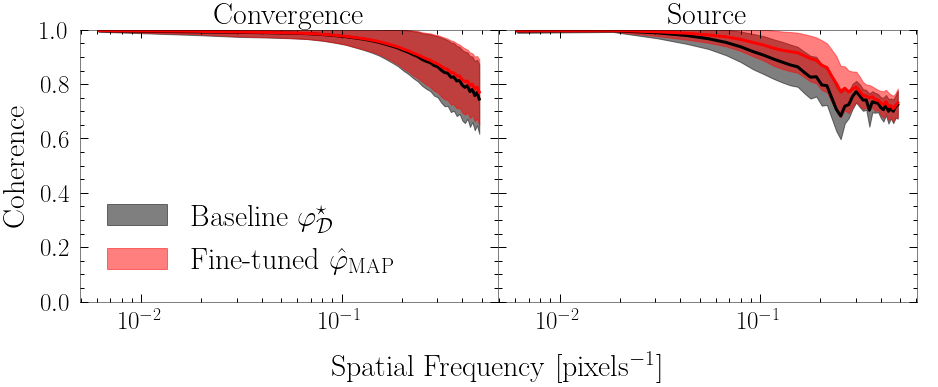

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
color = "k"
color2 = "r"

FOV = 7.69 # arcsec
pixels = 128

# f = np.array(hf["observation_frequencies"])
_, f = np.histogram(np.fft.fftfreq(pixels)[:pixels//2], bins=bins)
f = (f[:-1] + f[1:]) / 2
# sampling_rate = FOV / pixels

# kappa
gamma_ro = kappa_ro_coherence
gamma = kappa_coherence
# gamma_ro = hf["kappa_coherence_spectrum_reoptimized"][:] # coherence of log kappa, not kappa
# gamma = hf["kappa_coherence_spectrum"][:]
bins=gamma.shape[1]

gamma_mean = gamma.mean(axis=0)
gamma_std = gamma.std(axis=0)
gamma_ro_mean = gamma_ro.mean(axis=0)
gamma_ro_std = gamma_ro.std(axis=0)
# lam = 1/f/2 # scale

ax1.plot(f, gamma_mean, "-", color=color, lw=3)
ax1.fill_between(f, gamma_mean - gamma_std, gamma_mean + gamma_std, color=color, alpha=0.5, label=r"Baseline $\varphi_{\mathcal{D}}^{\star}$")
ax1.plot(f, gamma_ro_mean, "-", color=color2, lw=3)
ax1.fill_between(f, gamma_ro_mean - gamma_ro_std, gamma_ro_mean + gamma_ro_std, color=color2, alpha=0.5, label=r"Fine-tuned $\hat{\varphi}_{\mathrm{MAP}}$")
# ax1.invert_xaxis()
ax1.set_xscale("log")
ax1.set_ylim(0, 1)
ax1.set_title("Convergence", fontsize=30)
ax1.legend(loc="lower left", fontsize=30)
ax1.set_ylabel(r"Coherence", labelpad=10, fontsize=30)
ax1.tick_params(axis='both', pad=10, labelsize=25)


# source
gamma_ro = source_ro_coherence
gamma = source_coherence
# gamma_ro = hf["source_coherence_spectrum_reoptimized"][:]
# gamma = hf["source_coherence_spectrum"][:]
# bins=gamma.shape[1]

gamma_mean = gamma.mean(axis=0)
gamma_std = gamma.std(axis=0)
gamma_ro_mean = gamma_ro.mean(axis=0)
gamma_ro_std = gamma_ro.std(axis=0)
# lam = 1/f/2 # scale

ax2.plot(f, gamma_mean, "-", color=color, lw=3)
ax2.fill_between(f, gamma_mean - gamma_std, gamma_mean + gamma_std, color=color, alpha=0.5)
ax2.plot(f, gamma_ro_mean, "-", color=color2, lw=3)
ax2.fill_between(f, gamma_ro_mean - gamma_ro_std, gamma_ro_mean + gamma_ro_std, color=color2, alpha=0.5)
# ax2.invert_xaxis()
ax2.set_xscale("log")
ax2.set_title("Source", fontsize=30)
ax2.tick_params(axis='both', pad=10, labelsize=25)

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"Spatial Frequency [pixels$^{-1}$]", labelpad=20, fontsize=30)

plt.subplots_adjust(wspace=0, hspace=0);
# plt.savefig("../../../Papers/Censai-paper/figures/coherence_spectrum.png", facecolor="w")